# Extraction des caractéristiques et test sur la normalisation des données

In [2]:
from __future__ import print_function
import sys
import os
import logging
import six
import tqdm
#from data import clean_data
from sklearn import preprocessing

from radiomics import featureextractor, getFeatureClasses
import radiomics
%config Completer.use_jedi = False
import SimpleITK as sitk
import nibabel as nib
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


## Extraction des caractéristiques des données 3D IRM

### Fonction extract_features :

- ls : liste des noms de fichiers de données

- normalize : booléen, permet de normaliser les niveaux de gris des images -> à mettre sur False

- enables_features :  liste des classes de features à extraires  ['firstorder','shape','glcm','glszm','glrlm','ngtdm','gldm']

In [3]:

def extract_features(ls,normalize = False, enabled_features = ['firstorder','shape']) :
    settings = {}
    settings['binWidth'] = 25
    settings['interpolator'] = 'sitkBSpline'
    settings['verbose'] = True
    settings['force2D'] = True
    settings['normalize'] = normalize
    settings['force2Ddimension'] = 0

    settings['resampledPixelSpacing'] = [3, 3, 3] 

    extractor = featureextractor.RadiomicsFeatureExtractor(**settings)

    if enabled_features != "all" :
        extractor.disableAllFeatures()
        for feature_class in enabled_features :
            extractor.enableFeatureClassByName(feature_class)
    
    print('')
    print('Enabled features:\n\t', extractor.enabledFeatures)

    extractor.settings
    
    all_dat = pd.DataFrame()
    for imageName in tqdm.tqdm(ls):
        try:
            maskName = imageName.replace('_NAT','').replace('.nii','_masked.nii')
            classe_name = imageName.split('\\')[-2].split('_')[1]
            temps_inj = imageName.split('_')[-1].split('.')[0]
            patient_num = imageName.split('\\')[-1].split('_')[0]

            mask_sitk = sitk.ReadImage(maskName) !=  0  
            print(imageName)
            mr_sitk = sitk.ReadImage(imageName)
            
            featureVector = extractor.execute(mr_sitk, mask_sitk)
                                
            df_idx = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in featureVector.items() ])).iloc[0]
            df_idx['classe_name'] = classe_name
            df_idx['temps_inj'] = temps_inj
            df_idx['patient_num'] = patient_num
            df_idx = pd.DataFrame(df_idx).T
            
            all_dat = pd.concat([df_idx,all_dat])
            
        except:
            pass
    return all_dat

In [4]:
#ls_image =sorted(glob.glob('*_NAT*/*_NAT*/*.nii'))
ls_image =sorted(glob.glob('./*_NAT*/*.nii'))
ls_image
ls_image=ls_image[1:10]
ls_image

['./Dataset_CCK_NAT/10_PORT.nii',
 './Dataset_CCK_NAT/10_TARD.nii',
 './Dataset_CCK_NAT/10_VEIN.nii',
 './Dataset_CCK_NAT/11_ART.nii',
 './Dataset_CCK_NAT/11_PORT.nii',
 './Dataset_CCK_NAT/11_TARD.nii',
 './Dataset_CCK_NAT/11_VEIN.nii',
 './Dataset_CCK_NAT/12_ART.nii',
 './Dataset_CCK_NAT/12_PORT.nii']

## Mon Playground à moi

### Sur les images

In [5]:
## Playground
mon_image_name = './Dataset_CCK_NAT/10_PORT.nii'
mon_image = sitk.ReadImage(mon_image_name)
print(mon_image.GetSize())
print(mon_image.GetSpacing()) #coefficient par pixel...


(320, 240, 72)
(1.09375, 1.09375, 3.0)


In [19]:
pixel_central = [i//2 for i in mon_image.GetSize()]
print(pixel_central)
print(mon_image.GetPixel(pixel_central))
print(mon_image[0:5,1:2,1:2].GetSize())
print(mon_image[0:5,1:2,1].GetSize())

[160, 120, 36]
73
(5, 1, 1)
(5, 1)


In [7]:
image_numpy = sitk.GetArrayFromImage(mon_image)
print(image_numpy.shape)

(72, 240, 320)


### Sur les masques

In [8]:
mon_mask_name= mon_image_name.replace('_NAT','').replace('.nii','_masked.nii') 
mon_mask = sitk.ReadImage(mon_mask_name)
mon_mask_array = sitk.GetArrayFromImage(mon_mask)
print(mon_mask_array.shape)

(72, 240, 320)


In [10]:
slice_36_mask = mon_mask_array[36,120:130,150:160]
print(slice_36_mask)

[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


## Retour à l'original

In [9]:
data = extract_features(ls_image,normalize=False,enabled_features="all")


Enabled features:
	 {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}


100%|██████████| 9/9 [00:00<00:00, 111353.20it/s]


In [10]:
data = clean_data(data)
# data.to_csv("data.csv")

NameError: name 'clean_data' is not defined

## Vérification du fonctionnement de pyradiomics sur la normalisation

In [34]:
settings = {}
settings['binWidth'] = 25
settings['interpolator'] = 'sitkBSpline'
settings['verbose'] = True
settings['force2D'] = True
settings['normalize'] = False
settings['force2Ddimension'] = 0

settings['resampledPixelSpacing'] = [2,2]

extractor = featureextractor.RadiomicsFeatureExtractor(**settings)

extractor.disableAllFeatures()
extractor.enableFeatureClassByName('firstorder')

#imageName = 'data_test\\Dataset_CCK_NAT\\Dataset_CCK_NAT\\1_ART.nii'
imageName =  ls_image[1]
print(imageName)
maskName = imageName.replace('_NAT','').replace('.nii','_masked.nii') 
classe_name = imageName.split('/')[-2].split('_')[1]
temps_inj = imageName.split('_')[-1].split('.')[0]
patient_num = imageName.split('/')[-1].split('_')[0]

mask_sitk = sitk.ReadImage(maskName) !=  0 
mr_sitk = sitk.ReadImage(imageName)

slice_num = 0
slice_mask = mask_sitk[:,:,slice_num]

while sitk.GetArrayFromImage(slice_mask).sum() <= 0:
    slice_num += 1
    slice_mask = mask_sitk[:,:,slice_num]

slice_mask = mask_sitk[:,:,slice_num]
slice_img = mr_sitk[:,:,slice_num]   

./Dataset_CCK_NAT/10_TARD.nii


In [35]:
imageName

'./Dataset_CCK_NAT/10_TARD.nii'

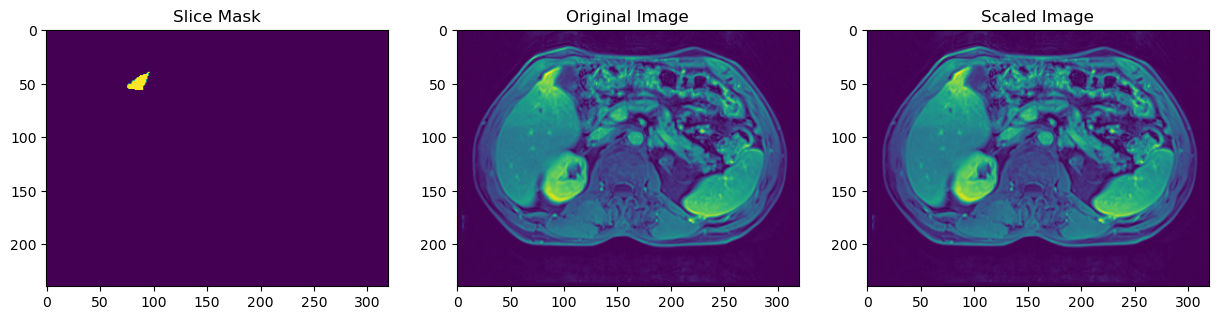

In [36]:
coef = 2
slice_img_n = coef * slice_img

plt.figure(figsize=(15, 5))  

plt.subplot(1, 3, 1)
plt.imshow(sitk.GetArrayFromImage(slice_mask))
plt.title('Slice Mask')

plt.subplot(1, 3, 2)
plt.imshow(sitk.GetArrayFromImage(slice_img))
plt.title('Original Image')


plt.subplot(1, 3, 3)
plt.imshow(sitk.GetArrayFromImage(slice_img_n))
plt.title('Scaled Image')

plt.show()

In [26]:
featureVector = extractor.execute(slice_img, slice_mask)


df_idx = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in featureVector.items() ])).iloc[0]
df_idx['classe_name'] = classe_name
df_idx['temps_inj'] = temps_inj
df_idx['patient_num'] = patient_num

dat =pd.DataFrame(df_idx).T

#dat = clean_data(dat)
dat   

(55,)


,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,diagnostics_Image-original_Dimensionality,diagnostics_Image-original_Spacing,...,original_firstorder_Range,original_firstorder_RobustMeanAbsoluteDeviation,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_TotalEnergy,original_firstorder_Uniformity,original_firstorder_Variance,classe_name,temps_inj,patient_num
0,3.1.0a2,1.21.6,2.1.0,1.3.0,3.7.12,NaN,NaN,5aa6e92ff886985bf4731ccb9e914f619569c425,2D,1.09375,...,234.0,18.16418798334326,283.0863259229034,-1.8355565097777384,16989228.0,0.28871484514061946,3115.9095763616942,CCK,TARD,10


In [27]:
featureVector = extractor.execute(slice_img_n, slice_mask)

df_idx = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in featureVector.items() ])).iloc[0]
df_idx['classe_name'] = classe_name
df_idx['temps_inj'] = temps_inj
df_idx['patient_num'] = patient_num

dat_scaled =pd.DataFrame(df_idx).T

#dat_scaled = clean_data(dat_scaled)
dat_scaled  

,diagnostics_Versions_PyRadiomics,diagnostics_Versions_Numpy,diagnostics_Versions_SimpleITK,diagnostics_Versions_PyWavelet,diagnostics_Versions_Python,diagnostics_Configuration_Settings,diagnostics_Configuration_EnabledImageTypes,diagnostics_Image-original_Hash,diagnostics_Image-original_Dimensionality,diagnostics_Image-original_Spacing,...,original_firstorder_Range,original_firstorder_RobustMeanAbsoluteDeviation,original_firstorder_RootMeanSquared,original_firstorder_Skewness,original_firstorder_TotalEnergy,original_firstorder_Uniformity,original_firstorder_Variance,classe_name,temps_inj,patient_num
0,3.1.0a2,1.21.6,2.1.0,1.3.0,3.7.12,NaN,NaN,36324ae0408015746c77587e1621821ef6b55aec,2D,1.09375,...,469.0,36.292682926829265,566.6394481069451,-1.8370595606702174,68069016.0,0.16696333214667142,12447.606265574941,CCK,TARD,10
